## Purpose

I present a small, custom CNN to remove noise from the images in the BMS dataset. The model has about 100K trainable parameters. It's not powerful enough to make missing bonds reappear, or to fix badly degraded atom labels.

I hope you find this model useful for:
* preprocessing the BMS datase
* feature extraction
* the beginning of a more complex model
* cleaning other molecule images?
* anything else (let me know!)

The model is trained using new synthetic data that's generated during training. Importantly, this model also perfoms well on the original BMS dataset images, meaninsg that we can use it to preprocess both original and newly generated images and be confident of consistent outptus to feed into later networks.

As an additional task, the CNN also separates the atom label text from the bond lines. This demonstrates that the network understands enough to be useful not only for cleaning data, but also for localised feature extraction.

## Example result

From this image in the original BMS dataset:

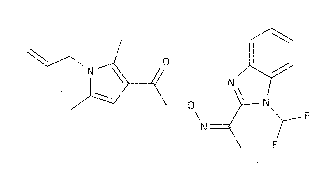

we get:

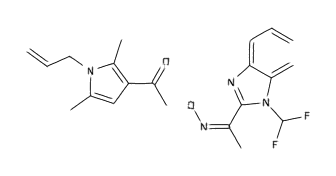

As a bonus, the atoms and bonds are outputted (partly successfully) as separate layers:

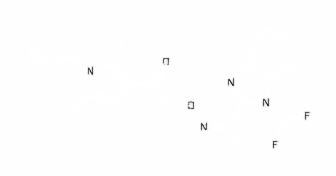

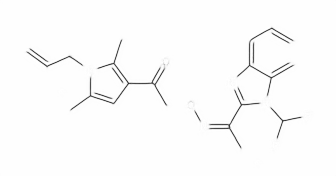

Interestingly, it seems to want to make the 'O' labels into rectangles!

 Below I install the same synthetic image generator that's used in my notebook https://www.kaggle.com/stainsby/improved-synthetic-data-for-bms-competition-v3.

In [ ]:
print('Importing synthetic image generation script, which also installs RDKIt and a few other utilities.')
print('Please wait as this may take a while…')
from bms_synth import random_molecule_image
print('Done.')

In [ ]:
import copy
from datetime import datetime
from io import BytesIO
from pathlib import Path

import numpy as np
import pandas as pd
from skimage.io import imread

import torch
from torch import nn
from torch import optim
from torchvision.transforms import Pad, RandomCrop
import torch.nn.functional as F

from PIL import Image
from rdkit import Chem

from matplotlib import pyplot as plt
import ipywidgets as widgets

from bms_synth import stretch_image

## Training and model options

This model performs significantly better *without* batch niormalisation, I guess this is because of the regularity of the data and possibly the fact the the network is fairly shallow. The model can be made even smaller by switching on separable convolutions, although the accuracy will decrease a bit.

The device used by Pytorch is also configured below, so change this as needed.

In [ ]:
DEVICE = 'cuda'

TRAINING_OPTIONS = {
    'num_iterations': 8000,
    'margin_fraction': 0.025,
    'patch_size': 96,
    'patches_per_image': 10,
    'batch_size': 15,
    'edge_loss_weight': 0.8,
    'white_pixel_weight': None,  # don't use - gives poor results
    'white_pixel_threshold': 1e-3,
    'device': DEVICE,
    'model_name': 'cnsnet3',
    'run_name': 'notebook001'
}

MODEL_OPTIONS = {
    'training_options': copy.deepcopy(TRAINING_OPTIONS),
    'use_batch_norm': False,  # False is best
    'use_separable_convolutions': False,  # False is best
    'use_global_pooling': True  # Global Average Pooling - True is best
}

In [ ]:
PROJECT_DIR = Path('..')
INPUT_DIR = PROJECT_DIR / 'input'
OUTPUT_DIR = Path('.')
BMS_INPUT_DIR = INPUT_DIR / 'bms-molecular-translation'
TRAIN_DATA_PATH = BMS_INPUT_DIR / 'train'
TRAIN_LABELS_PATH = BMS_INPUT_DIR / 'train_labels.csv'

In [ ]:
print('Reading training labels…')
TRAIN_LABELS = pd.read_csv(TRAIN_LABELS_PATH)
print(f'Read {len(TRAIN_LABELS)} training labels.')

## Data generation
During training, I grab random InChI IDs from the training set, using each of these to generate a synthetic 'degraded' image. I take a number of random patches from each image and supply these for training. Each patch has three layers: one for the degraded image - use for training inputs and a pair the bonds and the atom labels, which are used as labels.

In [ ]:
def image_generator(num=None):
    mol_index = np.random.randint(len(TRAIN_LABELS))
    mol_id, inchi = TRAIN_LABELS['image_id'][mol_index], TRAIN_LABELS['InChI'][mol_index]
    mol = Chem.inchi.MolFromInchi(inchi)
    count = 0
    while True:
        img, orig_bond_img, orig_atom_img = random_molecule_image(mol, margin_fraction=TRAINING_OPTIONS['margin_fraction'])
        yield (img, orig_bond_img, orig_atom_img)
        count +=1
        if num is not None and count == num:
            return


def patch_generator(num=None, dtype=torch.float32):
    patch_size = TRAINING_OPTIONS['patch_size']
    patches_per_image = TRAINING_OPTIONS['patches_per_image']
    cropper = RandomCrop(patch_size, pad_if_needed=True)
    if num is None:
        num_images = None
    else:
        num_images = num // patches_per_image
        if num % patches_per_image != 0:
            num_images += 1
    patch_count = 0
    for img, orig_bond_img, orig_atom_img in image_generator(num_images):
        img = torch.tensor(img, dtype=dtype)
        orig_bond_img = torch.tensor(orig_bond_img, dtype=dtype)
        orig_atom_img = torch.tensor(orig_atom_img, dtype=dtype)
        h, w = img.shape
        # We may need to pad images that cannot fit a patch
        if h < patch_size or w < patch_size:
            dh, dw = max(0, patch_size - h), max(0, patch_size - w)
            top_pad, left_pad = dh // 2, dw // 2
            bottom_pad, right_pad = dh - top_pad, dw - left_pad
            pad = Pad([left_pad, top_pad, right_pad, bottom_pad])
            img = pad(img)
            orig_bond_img = pad(orig_bond_img)
            orig_atom_img = pad(orig_atom_img)
        for _ in range(patches_per_image):
            i, j, h, w = RandomCrop.get_params(img, (patch_size, patch_size))
            img_patch, bond_patch, atom_patch = img[i:i+h, j:j+w], orig_bond_img[i:i+h, j:j+w], orig_atom_img[i:i+h, j:j+w]
            yield img_patch, bond_patch, atom_patch
            patch_count += 1
            if num is not None and patch_count == num:
                return

def image_widget(a, greyscale=True):
    img_bytes = BytesIO()
    img_pil = Image.fromarray(a)
    if greyscale:
        img_pil = img_pil.convert("L")
    else:
        img_pil = img_pil.convert("RGB")
    img_pil.save(img_bytes, format='PNG')
    return widgets.Image(value=img_bytes.getvalue(), margin='1em;')

def test_patch_generator(num):
    inchi = 'InChI=1S/C15H15F2NS/c1-10(18-2)11-6-7-15(14(17)8-11)19-13-5-3-4-12(16)9-13/h3-10,18H,1-2H3'
    for im, bond_im, atom_im  in patch_generator(num):
        #plt.figure(figsize=(4, 4/3)); plt.imshow(torch.cat([bond_im, atom_im, im], axis=-1), cmap='gray_r', interpolation='none'); plt.show()
        border = '1px solid pink'
        widget1 = image_widget((1 - im).numpy()*255)
        widget1.layout.border = border
        widget2 = image_widget((1 - bond_im).numpy()*255)
        widget2.layout.border = border
        widget3 = image_widget((1 - atom_im).numpy()*255)
        widget3.layout.border = border
        image_row = widgets.HBox([widget1, widget2, widget3])
        display(widgets.VBox([widgets.Label('training input + label (bonds + atoms)'), image_row]))
    return 'Done.'


test_patch_generator(num=10)

The NN modules below below are part of a larger collection. I haven't included some unused modules because they haven't been tested yet. `ResPair` allows you to recursivly build a network with skip connections at each power of two layers.

In [ ]:
class BaseRes(nn.Module):
    
    # resize_power - must be 0, -1 (downscale ×2) or 1 (upscale ×2).
    def __init__(
        self,
        in_channels, resize_power, out_channels, kernel_size,
        padding, groups, bias,
        separable, use_batch_norm, use_global_pooling
    ):
        super().__init__()
        if groups is None:
            if separable:
                groups = in_channels
            else:
                groups = 1
        if separable:
            bias = None
        if resize_power == 0:
            self.pooling = 1  # Effectively, that is no pooling.
            self.stride = 1
            if padding is None:
                padding = 1
            if out_channels is None:
                out_channels = in_channels
        elif resize_power == -1:
            self.pooling = 2
            self.stride = 2
            if padding is None:
                padding = 1
            if out_channels is None:
                out_channels = 2*in_channels
        elif resize_power == 1:
            self.pooling = 1  # Effectively, that is no pooling.
            self.stride = 2
            if kernel_size is None:
                kernel_size = 2
            if padding is None:
                padding = 0
            if out_channels is None:
                out_channels = in_channels // 2
        else:
            raise Exception('resize_power must be -1, 0 or 1')
        if kernel_size is None:
            kernel_size = 3
        if self.pooling > 1:
            self.pool = nn.MaxPool2d(self.pooling)
        else:
            self.pool = None
        if resize_power < 1:
            conv_class = nn.Conv2d
        else:
            conv_class = nn.ConvTranspose2d
        self.in_channels = in_channels
        self.out_channels = out_channels
        conv = conv_class(in_channels, out_channels, stride=self.stride, kernel_size=kernel_size, padding=padding, groups=groups, bias=bias)
        if use_batch_norm:
            self.conv = nn.Sequential(conv, nn.BatchNorm2d(out_channels))
        else:
            self.conv = conv
        # pointwise conv
        self.use_global_pooling = use_global_pooling
        if use_global_pooling:
            global_avg_pooling_channels = out_channels
            self.global_pooling = nn.AdaptiveAvgPool2d(1)
        else:
            global_avg_pooling_channels = 0
            self.global_pooling = None
        skip_channels = in_channels  # the skip connection shortcuts the input channels
        # We mix down the extra channels with a pointwise convolution so we get out_channels of output.
        mix_in_channels = out_channels + skip_channels + global_avg_pooling_channels
        mix_conv = nn.Conv2d(mix_in_channels, out_channels, kernel_size=1)
        if use_batch_norm:
            self.mix = nn.Sequential(mix_conv, nn.BatchNorm2d(out_channels))
        else:
            self.mix = mix_conv
    
    def forward(self, x):
        if self.pool is None:
            skip = x
        else:
            skip = self.pool(x)
        x = F.relu(self.conv(x))
        if self.global_pooling is not None:
            # throw some mean channels into the final mix
            means_per_channel = self.global_pooling(x)  # shape: N x C x 1 x 1
            global_avg_planes = means_per_channel*torch.ones_like(x)  # restored to: N x C x H x W
            x = torch.cat([x, global_avg_planes], axis=1)  # cat'd to: N x 2*C x H x W
        x = torch.cat((x, skip), axis=1)
        x = self.mix(x)
        return x


class ThruRes(BaseRes):
    
    def __init__(
        self, in_channels,
        out_channels=None,
        kernel_size=None,
        padding=None,
        groups=None,
        bias=True,
        separable=False,
        use_batch_norm=True,
        use_global_pooling=False
    ):
        super().__init__(
            in_channels,
            resize_power=0,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            groups=groups,
            bias=bias,
            separable=separable,
            use_batch_norm=use_batch_norm,
            use_global_pooling=use_global_pooling
        )

    
class ResPair(nn.Module):
    
    def __init__(self, first, second, use_batch_norm=True):
        super(ResPair, self).__init__()
        self.first = first
        self.second = second
        self.in_channels = first.in_channels
        self.out_channels = second.out_channels
        assert self.out_channels % self.in_channels == 0
        self.pooling = first.pooling * second.pooling
        if self.pooling > 1:
            self.pool = nn.MaxPool2d(self.pooling)
        # pointwise conv
        mix_conv = nn.Conv2d(self.out_channels + self.in_channels, self.out_channels, kernel_size=1)
        if use_batch_norm:
            self.mix = nn.Sequential(mix_conv, nn.BatchNorm2d(self.out_channels))
        else:
            self.mix = mix_conv
            
    
    def forward(self, x):
        skip = x
        if self.pooling > 1:
            skip = self.pool(x)
        x = self.second(self.first(x))
        x = torch.cat((x, skip), axis=1)
        x = self.mix(x)
        return x

## The model

Below is version 3 of my 'CNSNet'. I experimented with decreasing the spacial resolution at lower layers, and regenrating the resolution with transpose convolutions (like a Unet), and other mechanisms, but for this simple task, straight-through convolutions have worked the best so far - by a large margin. 

In [ ]:
class CleanAndSepNet3(nn.Module):
    
    def __init__(self, options):
        super().__init__()
        use_batch_norm = options['use_batch_norm']
        separable = options['use_separable_convolutions']
        use_global_pooling = options['use_global_pooling']
        def thru(out_channels):
            return ThruRes(out_channels, use_batch_norm=use_batch_norm, separable=separable, use_global_pooling=use_global_pooling)
        def respair(module1, module2):
            return ResPair(module1, module2, use_batch_norm=use_batch_norm)
        def convpair(out_channels):
            return respair(thru(out_channels), thru(out_channels))
        intro_conv = ThruRes(1, out_channels=32, kernel_size=7, padding=3, use_batch_norm=use_batch_norm, separable=separable, use_global_pooling=use_global_pooling)
        self.encoder = respair(
            respair(
                respair(intro_conv, thru(32)),
                convpair(32)
            ),
            respair(
                convpair(32),
                convpair(32)
            )
        )
        # pointwise convolution to extract the 2 output planes
        self.decoder = nn.Conv2d(32, 2, kernel_size=1, padding=0)
   
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training

After trying simple mean squared error loss between output and label pixels, I found that training was greatly improved by adding an MSE loss for the *differences* between neighbouring pixels (essentialy the first derivatives along each spacial dimension). This appears to give the resulting outputs cleaner edges. The 'edge loss' is so useful that it is weighted by 80% compared to the pixel MSE. You experiment with this yourself by changing the `edge_loss_weight` value in `TRAINING_OPTIONS`.

There is also a `white_pixel_weight` option to add weight to the pixels corresponding to non-background regions in the labels when calculating the MSEs, but I didn't find that this improved the results, so it is turned off.

In [ ]:
def batch_generator(batch_size):
    patches_per_image = TRAINING_OPTIONS['patches_per_image']
    patcher = patch_generator()
    is_first = True
    for im, bond_im, atom_im in patcher:
        if is_first or batch_item_count == batch_size:
            if is_first:
                is_first = False
            else:
                yield torch.stack(input_batch, axis=0), torch.stack(label_batch, axis=0)
            input_batch = []
            label_batch = []
            batch_item_count = 0
        h, w = im.shape
        # Augment with rotations
        # We prefer no relfections for now because the original dataset does not seem to any characters mirrored.
        krot = np.random.randint(4)
        if krot > 0:
            im = torch.rot90(im, krot, (0, 1))
            bond_im = torch.rot90(bond_im, krot, (0, 1))
            atom_im = torch.rot90(atom_im, krot, (0, 1))
        im = im.reshape(1, h, w)
        bond_im = bond_im.reshape(1, h, w)
        atom_im = atom_im.reshape(1, h, w)
        label_im = torch.cat([bond_im, atom_im], axis=0)
        input_batch.append(im)
        label_batch.append(label_im)
        batch_item_count += 1


def mse_loss(label, prediction):
    diff2 = (label - prediction)**2
    return diff2.mean()


def weighted_loss(error_values, white_pixels, white_pixel_weight=0.5):
    black_pixel_weight = 1 - white_pixel_weight
    black_pixels = 1 - white_pixels
    white_pixels_norm = white_pixels.sum()
    black_pixels_norm = black_pixels.sum()
    err_white = (error_values*white_pixels).sum()*white_pixel_weight
    err_black = (error_values*black_pixels).sum()*black_pixel_weight
    return err_white/white_pixels_norm + err_black/black_pixels_norm


def mse_loss_weighted(label, prediction, white_threshold=1e-3, white_pixel_weight=0.5):
    white_pixels = (label > white_threshold)*1
    diff2 = (label - prediction)**2
    return weighted_loss(diff2, white_pixels, white_pixel_weight=0.5)


def train(model_factory, options, num_iters=None, report_every=100):
    options = copy.deepcopy(options)
    training_options = options['training_options']
    model_name = training_options['model_name']
    run_name = training_options['run_name']
    device = training_options['device']
    batch_size = training_options['batch_size']
    t0 = datetime.now()
    model = model_factory(options).to(device)
    training_options['model'] = str(model)
    net_type = model.__class__.__name__
    options['net_type'] = net_type
    optimiser = optim.Adam(model.parameters())
    optimiser_type = optimiser.__class__.__name__
    options['optimiser_type'] = optimiser_type
    iter_count = 0
    loss_buffer = []
    print(f'Training "{model_name}" ({net_type}) "{run_name}" on {device} with minibatch size {batch_size}, optimised with {optimiser_type}…\n')
    for inputs, labels in batch_generator(batch_size):
        labels = labels
        iter_count += 1
        optimiser.zero_grad()
        outputs = model(inputs.to(device)).cpu()
        diff = outputs - labels
        loss_edge_weight = training_options['edge_loss_weight']
        white_pixel_weight = training_options['white_pixel_weight']
        if white_pixel_weight is None:
            mse_loss_pixels = mse_loss(labels, outputs)  #(diff**2).mean()
        else:
            white_threshold = training_options['white_pixel_threshold']
            white_pixels = (labels > white_threshold)*1
            mse_loss_pixels = mse_loss(labels, outputs)  #(diff**2).mean()
        if loss_edge_weight is None:
            loss = mse_loss_pixels
        else:
            dlabels_y = labels[:, :, 1:] - labels[:, :, :-1]
            doutputs_y = outputs[:, :, 1:] - outputs[:, :, :-1]
            dlabels_x = labels[:, :, :, 1:] - labels[:, :, :, :-1]
            doutputs_x = outputs[:, :, :, 1:] - outputs[:, :, :, :-1]
            if white_pixel_weight is None:
                loss_edge_y = mse_loss(dlabels_y, doutputs_y)
                loss_edge_x = mse_loss(dlabels_x , doutputs_x)
            else:
                loss_edge_y = weighted_loss((dlabels_y - doutputs_y)**2, white_pixels=1*(dlabels_y > white_threshold), white_pixel_weight=white_pixel_weight)
                loss_edge_x = weighted_loss((dlabels_x - doutputs_x)**2, white_pixels=1*(dlabels_x > white_threshold), white_pixel_weight=white_pixel_weight)
            loss_edge = (loss_edge_y + loss_edge_x)/2
            loss = (1 - loss_edge_weight)*mse_loss_pixels + loss_edge_weight*loss_edge
        loss.backward()
        optimiser.step()
        loss_buffer.append(loss.detach().cpu().item())
        if iter_count % (report_every//10) == 0:
            print('.', end='')
        if iter_count == 1 or iter_count % report_every == 0:
            print(f'\n######################## ITERATION #{iter_count}')
            print(f'Mean training loss (n={len(loss_buffer)}): {np.mean(loss_buffer)}')
            print(f'Elapsed time: {(datetime.now() - t0).total_seconds()/60:0.2f} minutes.')
            outputs_np = outputs.detach().cpu().numpy()
            outputs_bonds_np = outputs_np[0, 0]
            outputs_atoms_np = outputs_np[0, 1]
            outputs_combined_np = outputs_bonds_np + outputs_atoms_np
            _, axs = plt.subplots(1, 6, figsize=(6*2.5, 2.5), facecolor='#eee');
            axs[0].imshow(inputs.detach().cpu().numpy()[0, 0], vmin=0, vmax=1, cmap='gray_r')
            axs[0].set_title('input')
            axs[1].imshow(labels.detach().cpu().numpy()[0, 0], vmin=0, vmax=1, cmap='magma')
            axs[1].set_title('label (bonds)')
            axs[2].imshow(labels.detach().cpu().numpy()[0, 1], vmin=0, vmax=1, cmap='magma')
            axs[2].set_title('label (atoms)')
            axs[3].imshow(outputs_bonds_np, vmin=0, vmax=1, cmap='magma')
            axs[3].set_title('output (bonds)')
            axs[4].imshow(outputs_atoms_np, vmin=0, vmax=1, cmap='magma')
            axs[4].set_title('output (atoms)')
            axs[5].imshow(outputs_combined_np, vmin=0, vmax=1, cmap='gray_r')
            axs[5].set_title('output')
            for ax in axs:
                ax.axis('off')
            plt.show()
            loss_buffer = []
        if num_iters is not None and iter_count == num_iters:
            break
    print(f'Time taken: {(datetime.now() - t0).total_seconds()/60:0.2f} minutes.')
    print('\nSaving model…')
    model = model.cpu()
    model_file_name = f'{model_name}_{run_name}.pt'
    model_path = OUTPUT_DIR / model_file_name
    if model_path.exists():
        print(f'WARNING: model file {model_path} already exists. Adding a timestamp to the file name and continuing…')
        model_file_name = f'{model_name}_{run_name}_{timestamp()}.pt'
        model_path = OUTPUT_DIR / model_file_name
    torch.save({'model': model.state_dict(), 'options': options}, model_path)
    print(f'Saved to {model_path}.')
    print('Done.')
    return model_path


CNS_NET_PATH = train(lambda options: CleanAndSepNet3(options), MODEL_OPTIONS, TRAINING_OPTIONS['num_iterations'], report_every=500)

## Sanity Check

Below I check the model can handle an image from the _original_ BMS dataset. The results should be consistent when the model is applied to either the original synthetic images or the ones I generate during training. This appears to be have been successful.

In [ ]:
def load_model(filename):
    path = OUTPUT_DIR / filename
    loaded = torch.load(path)
    print(f'Loaded model from {path}.')
    options = loaded['options']
    model = CleanAndSepNet3(options)
    model.load_state_dict(loaded['model'])
    return model


def image_widget(a, greyscale=True):
    img_bytes = BytesIO()
    img_pil = Image.fromarray(a)
    if greyscale:
        img_pil = img_pil.convert("L")
    else:
        img_pil = img_pil.convert("RGB")
    img_pil.save(img_bytes, format='PNG')
    return widgets.Image(value=img_bytes.getvalue(), margin='1em;')


def prepare_image(img, size=None):
    h, w = img.shape
    # we need to pad to dimensions that are multiples of 16
    needs_pad = False
    if size is None:
        if h % 16 == 0:
            new_h = h
        else:
            new_h = ((h // 16) + 1)*16
            needs_pad = True
        if w % 16 == 0:
            new_w = w
        else:
            new_w = ((w // 16) + 1)*16
            needs_pad = True
    else:
        if isinstance(size, int):
            size = (size, size)
        new_h, new_w = size
        if h != size:
            needs_pad = True
        if w != size:
            needs_pad = True
    if needs_pad:
        margin_h = new_h - h
        margin_top = margin_h//2
        margin_bottom = margin_h - margin_top
        margin_w = new_w - w
        margin_left = margin_w//2
        margin_right = margin_w - margin_left
        padding = ((margin_top, margin_bottom), (margin_left, margin_right))
        img = np.pad(img, padding)
    else:
        padding = ((0, 0), (0, 0))
    return img, padding


def evaluate_model(model, img):
    img, _ = prepare_image(img)
    h, w = img.shape
    inputs = torch.tensor(img.reshape(1, 1, h, w), dtype=torch.float32)
    outputs = model(inputs).numpy()
    bond_img, atom_img = outputs[0, :2]
    return img, bond_img, atom_img


def sanity_check_model(model):
    mol_index = np.random.randint(len(TRAIN_LABELS))
    mol_id = TRAIN_LABELS['image_id'][mol_index]
    mol_train_img_path = TRAIN_DATA_PATH / mol_id[0] /mol_id[1] / mol_id[2] / (mol_id + '.png')
    img = imread(mol_train_img_path)
    img = 1 - img/255.0
    with torch.no_grad():
        img, bond_img, atom_img = evaluate_model(model, img)
    output_img = bond_img + atom_img
    #output_img = np.clip(output_img, 0, 1)
    #output_img = stretch_image(output_img)
    #output_img = output_img*(output_img > 0.1)
    border = '1px solid pink'
    widget1 = image_widget(255*(1 - img))
    widget1.layout.border = border
    widget2 = image_widget(255*(1 - output_img))
    widget2.layout.border = border
    img_row = widgets.HBox([
        widgets.VBox([widgets.Label('Input'), widget1]),
        widgets.VBox([widgets.Label('Output'), widget2])
    ])
    display(img_row)
    widget1 = image_widget(255*(1 - bond_img))
    widget1.layout.border = border
    widget2 = image_widget(255*(1 - atom_img))
    widget2.layout.border = border
    img_row = widgets.HBox([
        widgets.VBox([widgets.Label('Bond Output Layer'), widget1]),
        widgets.VBox([widgets.Label('Atom Output Layer'), widget2])
    ])
    display(img_row)
    print(f'No. of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')


with torch.no_grad():
    sanity_check_model(load_model(CNS_NET_PATH))

## Validation

In [ ]:
# TODO: run batches?
def validate_model(model, num=100):
    print(f'Validating {num} images…')
    t0 = datetime.now()
    measures = {
        'bond_mse': [],
        'atom_mse': [],
        'mse': [],
        'mse_weighted': []
    }
    for mol_index in range(num):
        mol_id, inchi = TRAIN_LABELS['image_id'][mol_index], TRAIN_LABELS['InChI'][mol_index]
        mol = Chem.inchi.MolFromInchi(inchi)
        img, bond_img, atom_img = random_molecule_image(mol, margin_fraction=TRAINING_OPTIONS['margin_fraction'])
        h, w = img.shape
        bond_img = bond_img.reshape(1, h, w)
        atom_img = atom_img.reshape(1, h, w)
        label = np.concatenate((bond_img, atom_img), axis=0)
        orig_img = img
        img, padding = prepare_image(img)
        h_padded, w_padded = img.shape
        inputs = torch.tensor(img.reshape(1, 1, h_padded, w_padded), dtype=torch.float32)
        outputs = model(inputs).numpy()
        # unpad
        (margin_top, margin_bottom), (margin_left, margin_right) = padding
        if h_padded != h:
            outputs = outputs[:, :, margin_top:-margin_bottom, :]
        if w_padded != w:
            outputs = outputs[:, :, :, margin_left:-margin_right]
        prediction = outputs[0, :]
        pred_bond_img = outputs[0, 0]
        pred_atom_img = outputs[0, 1]
        pred_img = np.clip(pred_bond_img + pred_atom_img, 0, 1)
        # find losses
        measures['bond_mse'].append(mse_loss(pred_bond_img, bond_img))
        measures['atom_mse'].append(mse_loss(pred_atom_img, atom_img))
        assert prediction.shape == label.shape, f'{prediction.shape} v. {label.shape}'
        mse = mse_loss(label, prediction)
        mse_weighted = mse_loss_weighted(label, prediction, white_pixel_weight=0.95)
        measures['mse'].append(mse)
        measures['mse_weighted'].append(mse_weighted)
        print('.', end='')
    measures['ave_bond_mse'] = np.mean(measures['bond_mse'])
    measures['ave_atom_mse'] = np.mean(measures['atom_mse'])
    measures['ave_mse'] = np.mean(measures['mse'])
    measures['ave_mse_weighted'] = np.mean(measures['mse_weighted'])
    print()
    print()
    print(f'Average MSE: {measures["ave_mse"]:0.8f}')
    print(f'Average weighted MSE: {measures["ave_mse_weighted"]:0.8f}')
    print()
    print(f'Finished. Time taken: {(datetime.now() - t0).total_seconds()/60:0.2f} minutes.')


with torch.no_grad():
    validate_model(load_model(CNS_NET_PATH), 500)